In [2]:
import numpy as np
import torch
import esm
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt
from networkx.drawing import spring_layout


In [3]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

In [4]:
sequence = "MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSVSYDQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKKKYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPPLLECVTWIVLKEPISVSSEQVLKFRKLNFNGEGEPEELMVDNWRPAQPLKNRQIKASFK"


In [5]:
# --- Sequenz und Batch-Converter -------------------------------
batch_converter = alphabet.get_batch_converter()
_, _, batch_tokens = batch_converter([("P00918", sequence)])

# --- Kontaktvorhersage -----------------------------------------
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
contact_map = results["contacts"][0]

In [6]:
contact_map

tensor([[5.0700e-02, 1.4922e-01, 5.7543e-03,  ..., 9.0072e-03, 1.2686e-02,
         1.8058e-02],
        [1.4922e-01, 1.9535e-01, 1.1364e-03,  ..., 7.4170e-03, 8.5067e-03,
         9.1978e-03],
        [5.7543e-03, 1.1364e-03, 5.6415e-04,  ..., 7.3950e-03, 8.5850e-03,
         7.8741e-03],
        ...,
        [9.0072e-03, 7.4170e-03, 7.3950e-03,  ..., 1.3410e-02, 3.4597e-03,
         3.3610e-02],
        [1.2686e-02, 8.5067e-03, 8.5850e-03,  ..., 3.4597e-03, 1.7206e-07,
         1.9202e-07],
        [1.8058e-02, 9.1978e-03, 7.8741e-03,  ..., 3.3610e-02, 1.9202e-07,
         2.6606e-01]])

In [7]:
def build_protein_hypergraph_from_contact_map(contact_map: np.ndarray,
                                              sequence: str,
                                              threshold: float = 0.5,
                                              trade_name: str = "P00918",
                                              combine_nodes: bool = True,
                                              plot: bool = True):
    """
    Builds a protein hypergraph from ESM-predicted contact probabilities, ensuring unique hyperedges.

    Args:
        contact_map (np.ndarray): L×L matrix of contact probabilities.
        sequence (str): Protein sequence of length L.
        threshold (float): Probability cutoff to include contacts.
        trade_name (str): Identifier for plot title.
        plot (bool): Whether to visualize the hypergraph.

    Returns:
        hyperedges (dict): Mapping edge_id → tuple of residue indices.
        node_labels (dict): Mapping residue index → amino acid letter.
    """
    L = contact_map.shape[0]

    # 1) Build and deduplicate hyperedges on the fly
    seen_sets = set()
    hyperedges = {}
    edge_counter = 0
    for i in range(L):
        partners = np.where(contact_map[i] >= threshold)[0].tolist()
        if partners:
            nodes = tuple(sorted({i, *partners}))
            fs = frozenset(nodes)
            if fs not in seen_sets:
                seen_sets.add(fs)
                hyperedges[f"he_{edge_counter}"] = nodes
                edge_counter += 1

    # 2) Add a global hyperedge spanning only residues that appear in any contact (when combine_nodes)
    nodes_with_edges = set()
    if combine_nodes:
        for nodes in hyperedges.values():
            nodes_with_edges.update(nodes)
    else:
        nodes_with_edges = range(L)
    all_nodes = tuple(sorted(nodes_with_edges))
    if all_nodes and frozenset(all_nodes) not in seen_sets:
        hyperedges[trade_name] = all_nodes
        edge_counter += 1
    # 3) Node labels: amino acid letters
    node_labels = {i: sequence[i] for i in range(L)}
    #global protein node
    node_labels = {i: sequence[i] for i in range(L)}
    node_labels[L+1] = trade_name
    hyperedges[trade_name] = hyperedges[trade_name] + (L+1,)
    # 4) Optional visualization with customizable draw parameters
    if plot:
        H = hnx.Hypergraph(hyperedges)
        plt.figure(figsize=(40, 24))  # Increased figure size for better readability
        hnx.draw(
            H,
            with_node_labels=True,
            node_labels=node_labels,
            with_edge_labels=True,
            layout=spring_layout
        )
        plt.title(f"Hypergraph of {trade_name}")
        plt.show()

    return hyperedges, node_labels

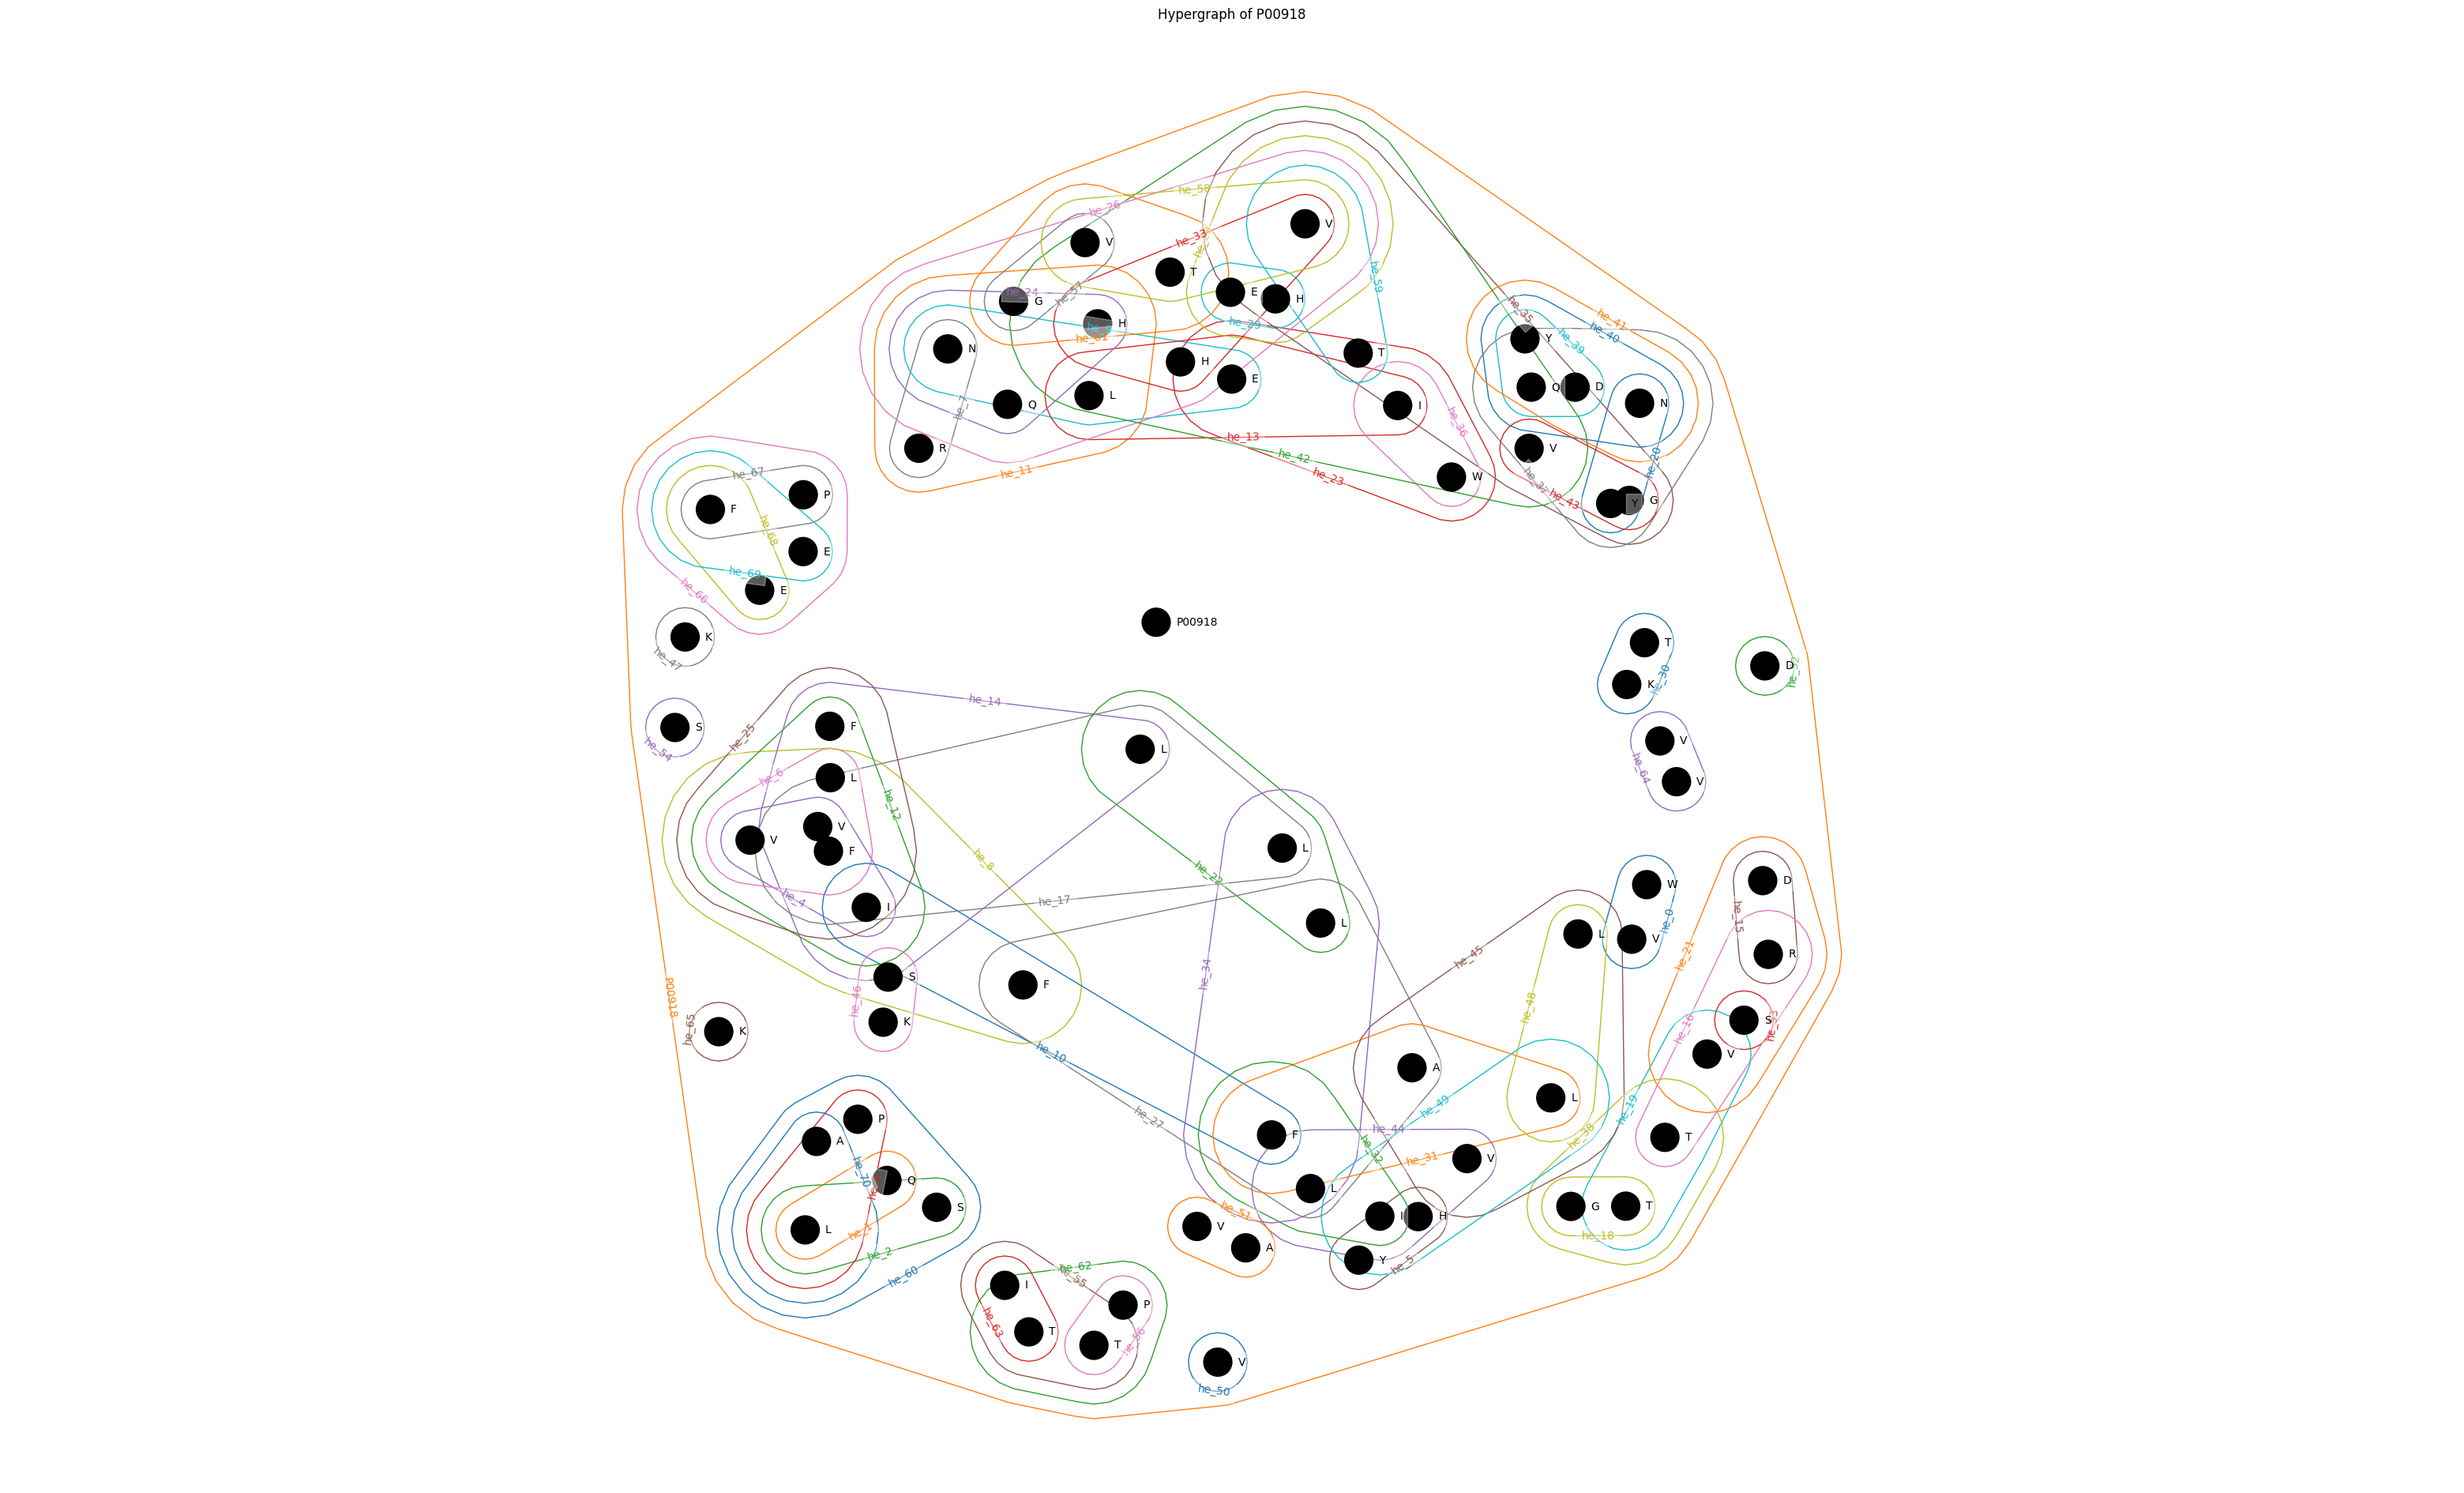

({'he_0': (15, 30),
  'he_1': (27, 201),
  'he_2': (28, 201),
  'he_3': (29, 201),
  'he_4': (48, 58, 67, 69),
  'he_5': (50, 121),
  'he_6': (56, 67, 69),
  'he_7': (57, 66),
  'he_8': (48, 58, 65, 67, 69),
  'he_9': (59, 66, 68),
  'he_10': (58, 65, 94),
  'he_11': (57, 59, 66, 91, 93),
  'he_12': (48, 56, 58, 67, 92),
  'he_13': (59, 68, 90),
  'he_14': (48, 56, 58, 69, 78, 92),
  'he_15': (71, 88),
  'he_16': (77, 86, 88),
  'he_17': (69, 78, 89),
  'he_18': (85, 124),
  'he_19': (77, 86, 124),
  'he_20': (87, 123),
  'he_21': (71, 77, 88),
  'he_22': (78, 89, 119),
  'he_23': (68, 90, 122),
  'he_24': (66, 91, 93),
  'he_25': (67, 69, 92),
  'he_26': (66, 91, 93, 118, 141),
  'he_27': (65, 94, 115, 117, 119),
  'he_28': (95, 105, 141),
  'he_29': (95, 105),
  'he_30': (107, 112),
  'he_31': (94, 115, 146),
  'he_32': (94, 117, 144),
  'he_33': (93, 118, 141),
  'he_34': (89, 94, 119),
  'he_35': (120, 141, 143),
  'he_36': (90, 122),
  'he_37': (87, 123, 135, 137),
  'he_38': (85,

In [8]:
build_protein_hypergraph_from_contact_map(contact_map, sequence)

In [9]:
def create_shared_protein_hypergraph(proteins,
                                    model,
                                    alphabet,
                                    threshold: float = 0.5,
                                    plot: bool = True):
    """
    Merges multiple protein hypergraphs into a shared global hypergraph.

    Args:
        proteins: List of (prot_id, sequence) tuples.
        model: ESM model for contact prediction.
        alphabet: Corresponding alphabet for batch converter.
        threshold: Contact probability cutoff.
        plot: Whether to visualize the final shared hypergraph.

    Returns:
        global_node_labels: Mapping global node idx → label.
        global_hyperedges: Mapping edge label → list of global node indices.
    """
    batch_converter = alphabet.get_batch_converter()
    global_hyperedges = {}
    helper_labels = {}  # for duplication detection (node symbols)
    global_node_labels = {}
    offset = 0

    # 1) Iterate proteins
    for prot_id, sequence in proteins:
        # Contact prediction
        _, _, batch_tokens = batch_converter([(prot_id, sequence)])
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)
        contact_map = results["contacts"][0].cpu().numpy()
        # Local hypergraph
        local_edges, local_nodes = build_protein_hypergraph_from_contact_map(
            contact_map, sequence, threshold, trade_name=prot_id
        )
        # Map to global indices
        local_to_global = {}
        for local_idx, aa in local_nodes.items():
            gidx = offset + local_idx
            global_node_labels[gidx] = f"{aa}{local_idx}_{prot_id}"
            local_to_global[local_idx] = gidx
        offset += len(local_nodes)
        # Add edges
        for edge_label, nodes in local_edges.items():
            global_nodes = [local_to_global[n] for n in nodes]
            # use node symbols for duplication test
            helper = [local_nodes[n] for n in nodes]
            # Deduplication
            duplicate = False
            for exist_lbl, exist_helper in helper_labels.items():
                if set(helper) == set(exist_helper):
                    duplicate = True
                    break
            if not duplicate:
                global_hyperedges[f"{edge_label}"] = global_nodes
                helper_labels[f"{edge_label}"] = helper
    # 2) Optional plot
    if plot:
        H = hnx.Hypergraph(global_hyperedges)
        plt.figure(figsize=(20, 12))
        hnx.draw(
            H,
            with_node_labels=True,
            node_labels=global_node_labels,
            with_edge_labels=True,
        )
        plt.title("Shared Protein Hypergraph")
        plt.show()

    return global_node_labels, global_hyperedges

In [10]:
sequence2="HHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSATEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQES"

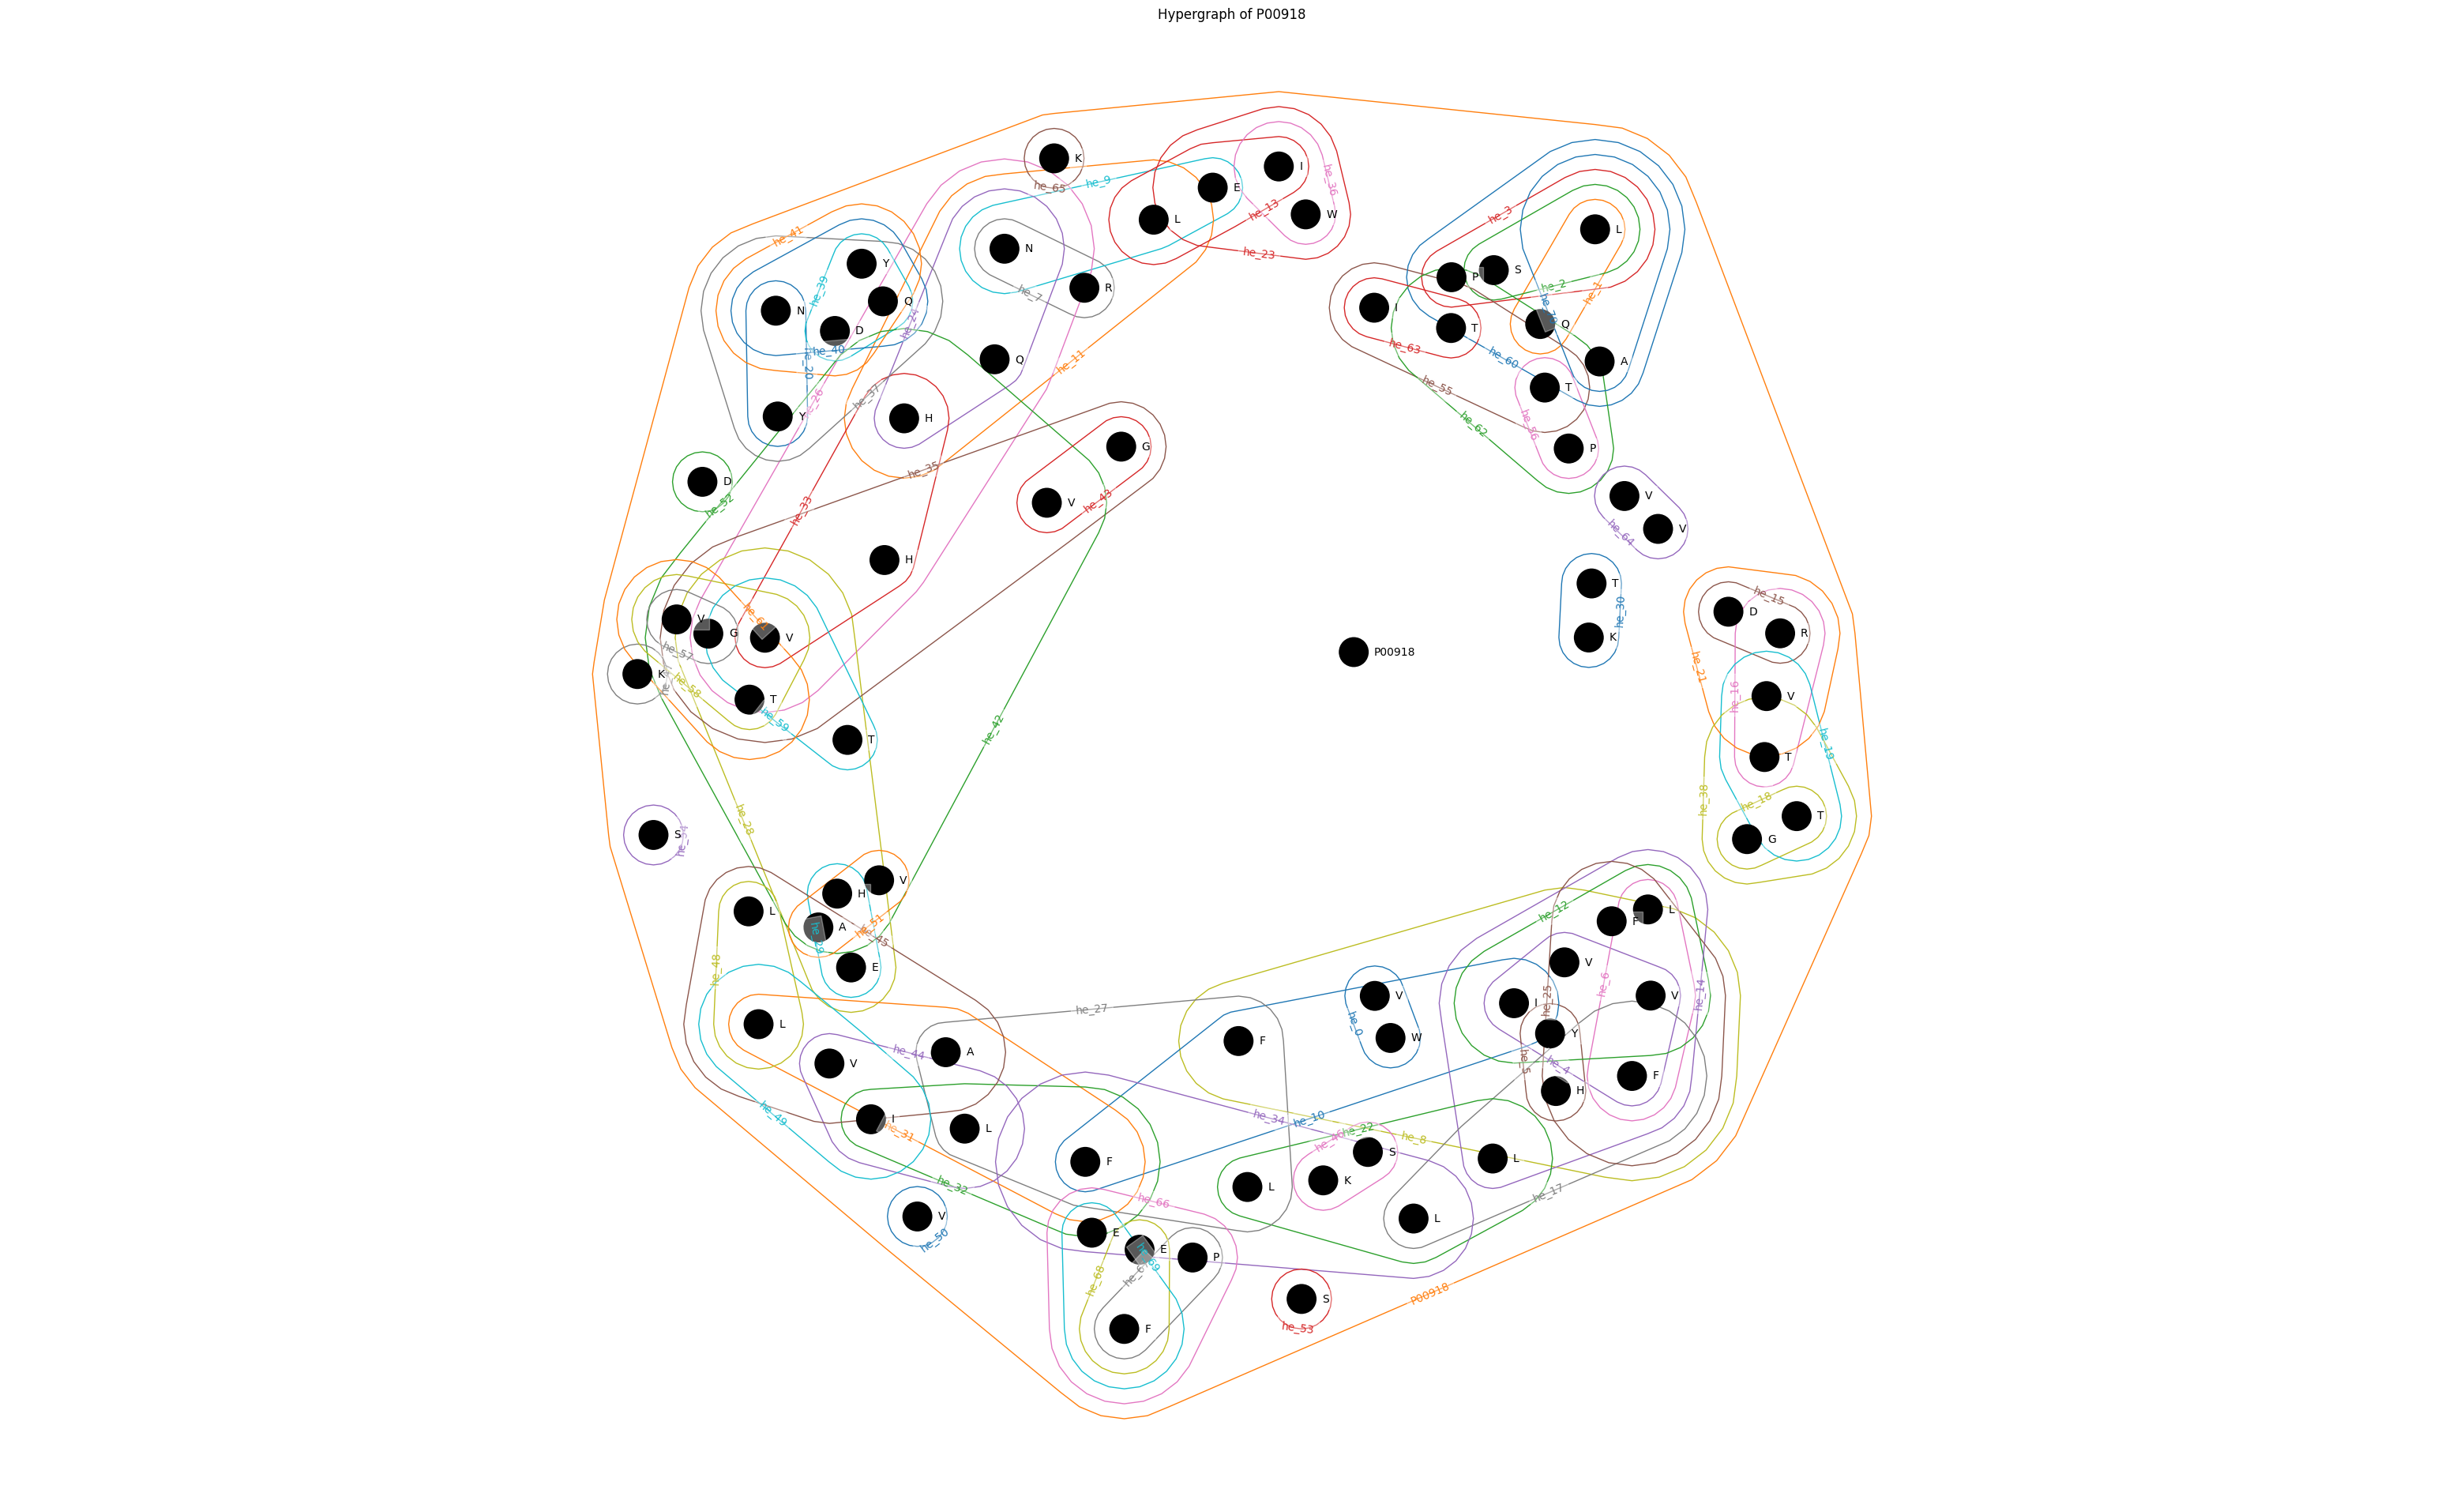

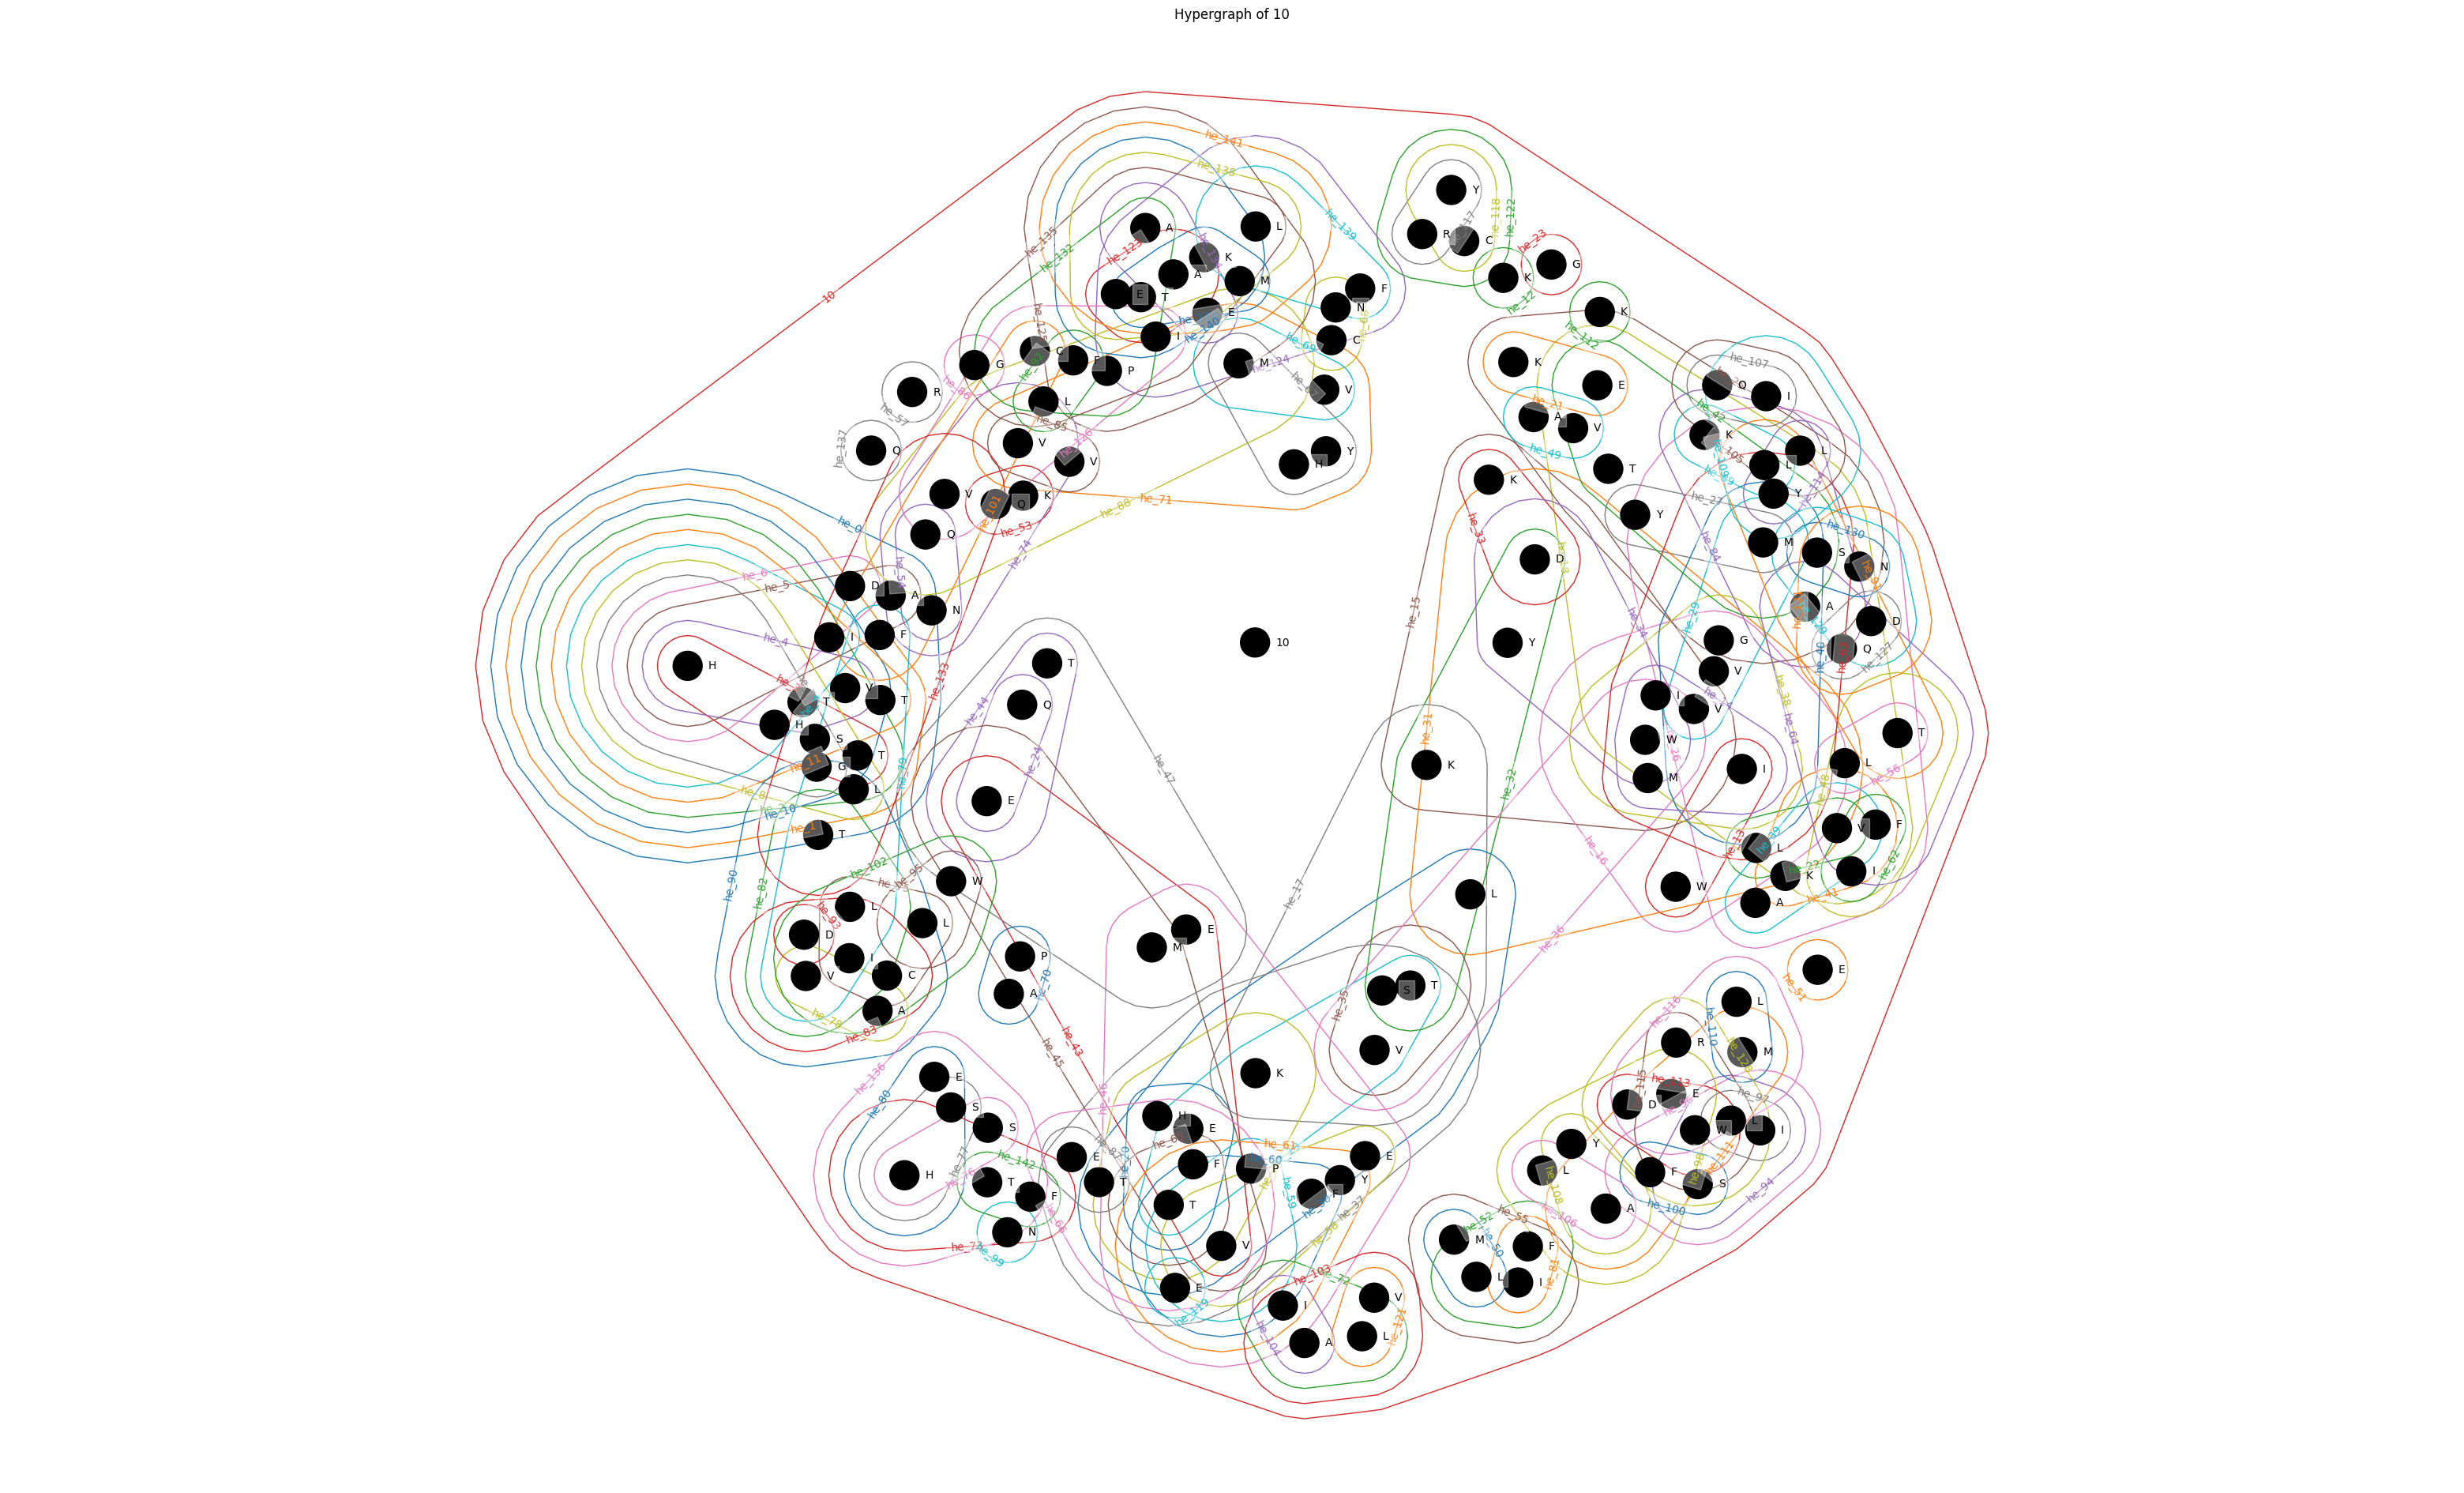

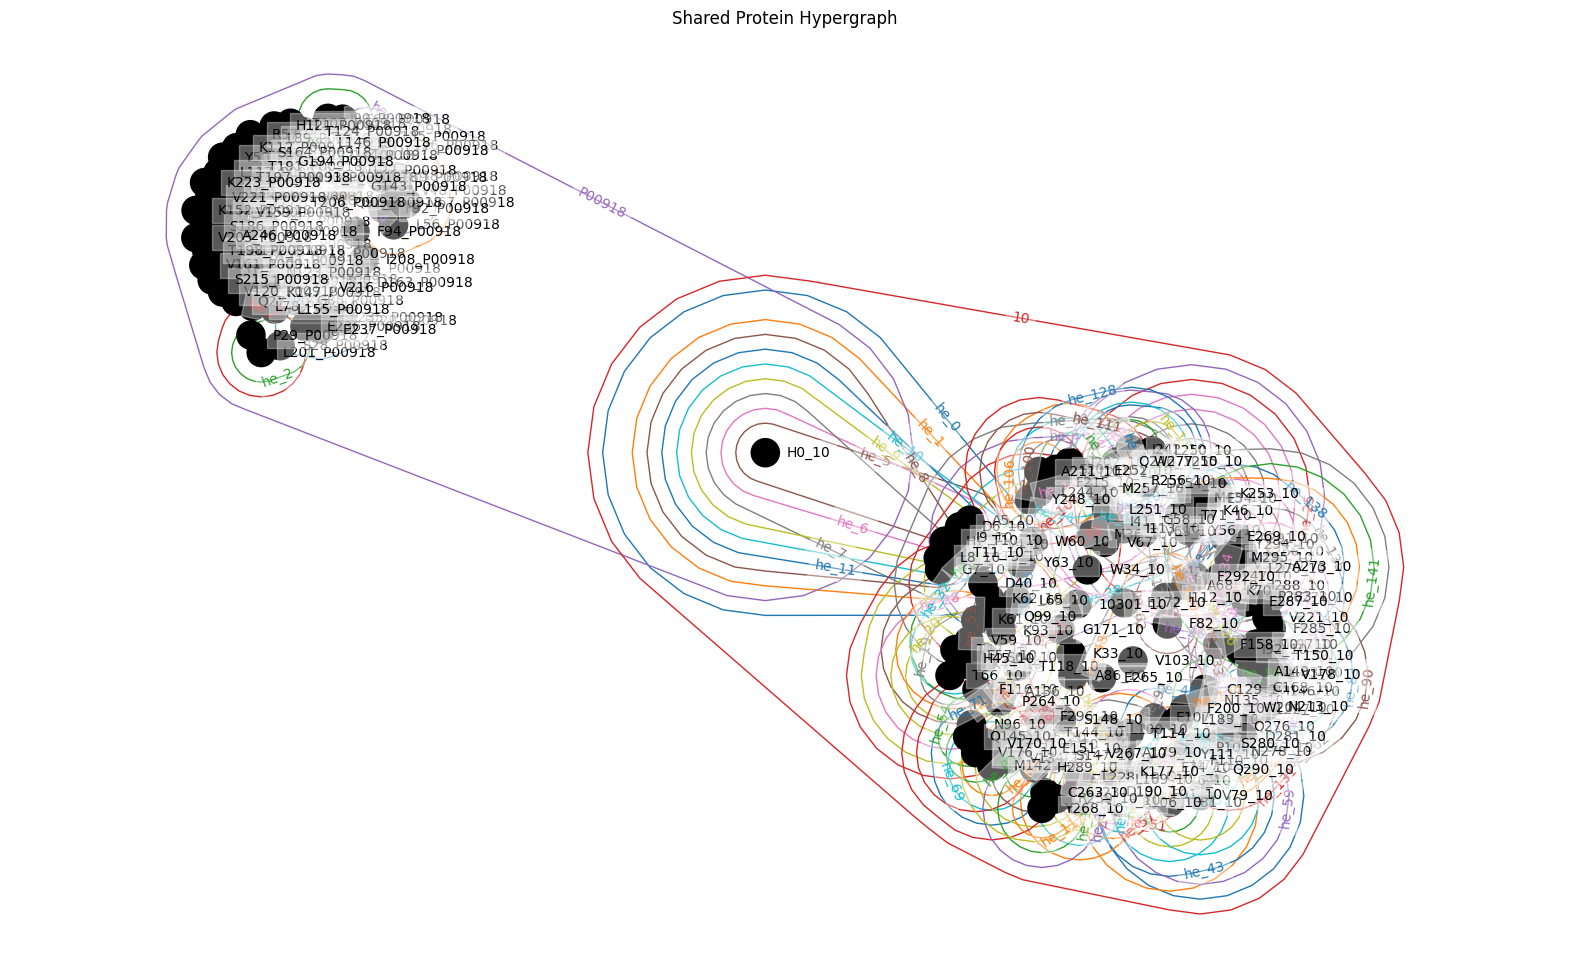

({0: 'M0_P00918',
  1: 'S1_P00918',
  2: 'H2_P00918',
  3: 'H3_P00918',
  4: 'W4_P00918',
  5: 'G5_P00918',
  6: 'Y6_P00918',
  7: 'G7_P00918',
  8: 'K8_P00918',
  9: 'H9_P00918',
  10: 'N10_P00918',
  11: 'G11_P00918',
  12: 'P12_P00918',
  13: 'E13_P00918',
  14: 'H14_P00918',
  15: 'W15_P00918',
  16: 'H16_P00918',
  17: 'K17_P00918',
  18: 'D18_P00918',
  19: 'F19_P00918',
  20: 'P20_P00918',
  21: 'I21_P00918',
  22: 'A22_P00918',
  23: 'K23_P00918',
  24: 'G24_P00918',
  25: 'E25_P00918',
  26: 'R26_P00918',
  27: 'Q27_P00918',
  28: 'S28_P00918',
  29: 'P29_P00918',
  30: 'V30_P00918',
  31: 'D31_P00918',
  32: 'I32_P00918',
  33: 'D33_P00918',
  34: 'T34_P00918',
  35: 'H35_P00918',
  36: 'T36_P00918',
  37: 'A37_P00918',
  38: 'K38_P00918',
  39: 'Y39_P00918',
  40: 'D40_P00918',
  41: 'P41_P00918',
  42: 'S42_P00918',
  43: 'L43_P00918',
  44: 'K44_P00918',
  45: 'P45_P00918',
  46: 'L46_P00918',
  47: 'S47_P00918',
  48: 'V48_P00918',
  49: 'S49_P00918',
  50: 'Y50_P00918',


In [11]:
create_shared_protein_hypergraph([
    ("P00918", sequence),
       ("10", sequence2),
], model, alphabet)